In [24]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
import random
from matplotlib import pylab
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature
from keras.utils import np_utils
from keras.layers import Dense,Activation
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD,Adagrad,Adam
from collections import Counter
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt

In [33]:
frame = pd.read_csv('preprocess_result.csv') 
# 数据不均衡
all_columns = frame.columns
split_rate = 5/6

In [34]:
# 按照 1:2 的比例得到训练数据和测试数据
def getTrainData():
    one = frame[frame['y'] == 1]
    zero = frame[frame['y'] == 0]
    shuffle(one);shuffle(zero)
    len_one = one.shape[0];len_zero = zero.shape[0]
    train_data = pd.concat([one[:int(len_one * split_rate)] , zero[: int(len_zero * split_rate)]], sort = False, ignore_index = True)
    test_data = pd.concat([one[int(len_one * split_rate) :] , zero[int(len_zero * split_rate) :]],sort = False, ignore_index = True)
    return train_data,test_data

In [35]:


def resample_frame(frame):
    # 对正样本进行重新采样
#     num_attrs = ['age', 'duration', 'campaign', 'pdays', 'previous',
#                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
#                  'euribor3m', 'nr.employed']
    num_attrs = frame.columns
    n_rate = 4 # 针对 y = 1 重采样的比率
    one_data = frame[frame['y'] == 1]
    zero_data = frame[frame['y'] == 0]
    zero_data = zero_data.sample(None, 0.9)
    one_num_data = one_data[num_attrs]
    knc = NearestNeighbors(n_neighbors = 3)
    # one_num_data.head()
    knc.fit(one_num_data)
    # 对于每一个one 数据根据最近邻算法生成 8 个数据来对数据进行扩充
    one_data_result = []
    for i in range(one_data.shape[0]):
        one_data_i = one_data.iloc[i] # 
        one_not_num_data_i = one_data_i.drop(num_attrs)
        columns = one_not_num_data_i.keys()
        one_not_num_data_i = pd.concat([one_not_num_data_i] * n_rate)
        # 对非数值特征的属性进行扩展
        one_not_num_data_i_extend = pd.DataFrame(one_not_num_data_i.values.reshape(n_rate,-1),columns = columns)
        one_num_data_i = one_data_i[num_attrs]
        index = knc.kneighbors(one_num_data_i.values.reshape(1,-1),return_distance = False)[0]
        one_num_data_i_extend = []
        for random_i in range(n_rate):
            index_i = np.random.randint(0,3)
            tmp = one_num_data_i + random.random() * np.abs(one_num_data.iloc[index[index_i]] - one_num_data_i)
            one_num_data_i_extend.append(pd.DataFrame(tmp.values.reshape(1,-1), columns = num_attrs))
        # 对生成的数据进行组合
        one_num_data_i_extend = pd.concat(one_num_data_i_extend, ignore_index = True)

    #     print(one_num_data_i_extend)
        one_data_result_tmp = pd.concat([one_num_data_i_extend,one_not_num_data_i_extend],axis = 1)
        # 加上原来固有的数据
        one_data_result_tmp = pd.concat([pd.DataFrame(one_data.iloc[i].values.reshape(1,-1), columns = all_columns) , one_data_result_tmp],sort = False)
    #     print(one_data_result_tmp.head())
        one_data_result.append(one_data_result_tmp)
    one_data = pd.concat(one_data_result,sort = False,ignore_index = True)
    return pd.concat([zero_data,one_data],sort = False,ignore_index = True)


In [163]:
train_data,test_data = getTrainData()
train_data = shuffle(train_data)
train_data = resample_frame(train_data)
train_data_y = train_data['y']
train_data_x = train_data.drop(['y'],axis = 1)
test_data_y = test_data['y']
test_data_x = test_data.drop(['y'] , axis = 1)
# print(train_data.shape)

In [173]:
def plot_pr(ap, precision, recall, label=None):  
    pylab.figure(num=None, figsize=(6, 5))  
    pylab.xlim([0.0, 1.0])  
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')  
    pylab.ylabel('Precision')  
    pylab.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(ap))  
    pylab.fill_between(recall, precision, alpha=0.2)  
    pylab.grid(True, linestyle='-', color='0.75')  
    pylab.plot(recall, precision, lw=1)      
    pylab.show()
def plot_index(predict_prob_y):
    average_precision = average_precision_score(test_data_y, predict_prob_y)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
    precision, recall, _ = metrics.precision_recall_curve(test_data_y, predict_prob_y)
    plot_pr(average_precision,precision,recall)

def print_report(predict_prob_y):
    predict_y = (predict_prob_y > 0.4).astype(int)
    report = classification_report(test_data_y, predict_prob_y > 0.4,
                                       target_names = ['no', 'yes'])
    print(report)
    cnt_true = 0;cnt_false = 0;
    for true_y , predict_y_i in zip(test_data_y, predict_y):
        if true_y != predict_y_i and true_y == 1:
            cnt_true += 1
        if true_y != predict_y_i and true_y == 0:
            cnt_false += 1
    print('实际为 1 判定为 0的数量{0} 实际为 0 判定为 1 的数量 {1}'.format(cnt_true,cnt_false))
    print('accuracy is {0}'.format(np.mean(test_data_y.values == predict_y)))
def print_all(predict_prob_y):
    plot_index(predict_prob_y)
    print_report(predict_prob_y)

In [102]:
#### 逻辑回归 手写
class LR(object):
    def __init__(self,learning_rate = 1e-5,max_iterator = 10):
        self.learning_rate = learning_rate
        self.max_iterator = max_iterator
        self.w = None
    def train(self,train_data,train_label):
        self.w = np.zeros(train_data.shape[1] + 1)
        for iterator_i in range(self.max_iterator):
            for i,data in enumerate(train_data):
                data = np.append(data,1.0) #是种浅拷贝 ！！！
#                 print(type(data[0]),type(self.w[0]))
                tmp = np.dot(self.w,data.transpose())
                self.w += self.learning_rate * (data * train_label[i] - data * np.exp(tmp)/(1 + np.exp(tmp))) # there should be + 因为是最大化
    def predict(self,test):
        # print(self.w)
        test = np.append(test,1)
        return (1 - 1 / (1 + np.exp(np.dot(self.w,test.transpose()))))
                
                

In [104]:
lr = LR(max_iterator = 1000)
lr.train(train_data_x.values,train_data_y.values)
# print(type(train_data_x.iloc[0]))

Average precision-recall score: 0.62


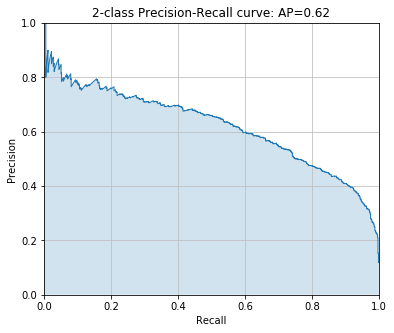

             precision    recall  f1-score   support

         no       0.98      0.87      0.92      6033
        yes       0.45      0.85      0.59       766

avg / total       0.92      0.86      0.88      6799

实际为 1 判定为 0的数量114 实际为 0 判定为 1 的数量 809
accuracy is 0.864244741873805


In [105]:
predict_y = []
for test in test_data_x.values:
    predict_y.append(lr.predict(test))
print_all(np.array(predict_y))
# 无过采样,欠采样的结果
#                  precision    recall  f1-score   support

#          no       0.94      0.95      0.95      3620
#         yes       0.60      0.56      0.58       460

# avg / total       0.91      0.91      0.91      4080

# 实际为 1 判定为 0的数量202 实际为 0 判定为 1 的数量 169

In [106]:

class Node(object):

    def __init__(self,is_leaf,label,attribute,attribute_value): # attribute 的value 作为划分
        self.is_leaf = is_leaf
        self.label = label
        self.attribute = attribute
        self.attribute_value = attribute_value
        self.children = dict()  #直接

class ID3(object):
    '''
        算法流程 李航p63
        输入：雪莲数据集D，特征集A，阈值epsilon
        (1) 若D中所有的实例属于同一类Ck,则将类Ck作为该节点的类标记
        (3) 计算A中的各个特征对D的信息增益，选择信息增益最大的特征Ag(采用连续值的处理方法)
        (4) 如果Ag的信息增益小于阈值epsilon。则置T为单节点树，并将D中的实例树最大的类Ck,作为该节点的类标记，返回T
        (5) 否则对Ag的每一个可能值ai,依Ag=ai将D分割为若干非空子集Di，将Di中实例数最大的类作为标记，构建子节点，由结点及其子节点构成树T，返回T
        (6) 对于第i个子节点，以Di为训练集，以A为特征集，递归调用(1) - (5),得到子树Ti,返回Ti
    '''
    def __init__(self,epsilon):
        self.epsilon = epsilon

    def entropy(self,x):
        total = sum(x)
        return -sum(x / total * np.log2(x / total))
    def binaryzationbyzero(self,data):
        data = data.astype(float)
        return np.round(data, 2)
    def binaryzation(self,img):
        cv_img = img.astype(np.uint8)
        _, cv_img = cv2.threshold(cv_img,50,1,cv2.THRESH_BINARY_INV)
        return cv_img

    def train(self,data,label,attributes):
        self.attributes = attributes  # 属性列
        self.attribute_value = dict()
        self.labels = list(set(label))
        for attribute_i in self.attributes:
            self.attribute_value[attribute_i] = tuple(Counter(data[:,attribute_i]).keys()) # every attribute have and cannot change
        self.root = self._train(data,label)

    def _train(self,data,label):
        # compute
        counter = Counter(label)
        mx = -1
        label_selected = -1
        for key, value in counter.items():
            if value > mx:
                mx = value
                label_selected = key
        if label_selected == -1:
            print('there is something wrong!! 1')

        if len(counter) == 1: # 只剩下一个属性
            # fw.write('1' + ' : '+str(label[0]) + '\n')
            node = Node(True,label[0],None,None)
            return node
        # if len(attributes) == 0: # 没有属性
        #     attributes = self.attribute
            # print(label)
            # fw.write('2'+ ' : '+ str(label_selected) + '\n')
            # node = Node(True,label_selected,None,None)
            # return node
        entropy_count = np.array(list(counter.values()))
        entropy_data = self.entropy(entropy_count)
        # print('entropy_data',entropy_data)
        mx_entropy = -1e9   #最大的信息增益

        slice_attribute = -1 # 切分的属性
        slice_attribute_value = -1 # 切分属性的值
        for attribute_i in self.attributes: # 计算每一个属性的熵
            sum = 0
            # for attribute_value_i in self.attribute_value[attribute_i]: # 对于某个属性，某个类别

#             index = np.argsort(data[:,attribute_i])
#             sorted_label = label[index]  # 对原始数据进行排序
#             sorted_data = data[index]

            slice_attribute_value_list = list(set(data[:,attribute_i]))

            for slice_attribute_value_i in range(len(slice_attribute_value_list) - 1):
                candidate_value = (slice_attribute_value_list[slice_attribute_value_i] + slice_attribute_value_list[slice_attribute_value_i + 1]) / 2
                # > candidate_value
                index = data[:, attribute_i] > candidate_value
                data_i = data[index]
                label_i = label[index]

                sum_tmp_1 = len(data_i) / len(data)
                sum_tmp_2 = 0

                for label_j in set(label_i):
                    data_j = data_i[label_i == label_j]   #
                    len_1 = len(data_j)
                    len_2 = len(data_i)
                    sum_tmp_2 += (len_1 / len_2 * np.log2(len_1 / len_2))

                sum += (sum_tmp_1 * sum_tmp_2)

                # <= candidate_value
                index = data[:, attribute_i] <= candidate_value
                data_i = data[index]
                label_i = label[index]

                sum_tmp_1 = len(data_i) / len(data)
                sum_tmp_2 = 0

                for label_j in set(label_i):
                    data_j = data_i[label_i == label_j]  #
                    len_1 = len(data_j)
                    len_2 = len(data_i)
                    sum_tmp_2 += (len_1 / len_2 * np.log2(len_1 / len_2))

                sum += (sum_tmp_1 * sum_tmp_2)

                entropy_tmp = entropy_data + sum
                if mx_entropy < entropy_tmp:
                    mx_entropy = entropy_tmp
                    slice_attribute = attribute_i
                    slice_attribute_value = candidate_value

        if mx_entropy < self.epsilon: # 小于最小的信息增益
            # fw.write('3'+' : ' + str(label_selected) + '\n')
            print('++++++++++++++',label)
            node = Node(True, label_selected,None,None)
            return node

        # print('slice_attribute ------ ', slice_attribute, 'label_selected ----- ', mx_entropy)
        # fw.write(str(mx_entropy) + ' ' + str(slice_attribute)+ '\n')
        # print(False,'label_selected -- > ',label_selected, 'slice_atttibute -- >',slice_attribute, ' slice_attribute_value --- > ',slice_attribute_value)
        node = Node(False,label_selected,slice_attribute,slice_attribute_value)
        # sub_attribute = []
        # for attribute_i in attributes:
        #     if attribute_i != slice_attribute:
        #         sub_attribute.append(attribute_i)      # important 应该使用局部变量，不要使用attributes.remove(attribute_i) 这是个大坑
        index = data[:,slice_attribute] <= slice_attribute_value
        sub_data = data[index]
        sub_label = label[index]
        node.children[0] = self._train(sub_data,sub_label)

        index = data[:, slice_attribute] > slice_attribute_value
        sub_data = data[index]
        sub_label = label[index]
        node.children[1] = self._train(sub_data,sub_label)
        return node
    def bfs(self):
        root = self.root
        self._bfs(root)

    def _bfs(self,root):
        que = Queue()
        que.put(root)
        while not que.empty():
            q = que.get()
            if q.is_leaf:
                print('label --- ',q.label)
            print('slice ',q.attribute)
            for edge in q.edge.keys():
                print('start edge ---  ', edge ,'\n')
                que.put(q.children[q.edge[edge]])
                print('end edge ---  ', '\n')
    def dfs(self,test):
        root = self.root
        return self._dfs(root,test)

    def _dfs(self,root,test):
        if root.is_leaf:
            return root.label
        if test[root.attribute] <= root.attribute_value:
            return self._dfs(root.children[0],test)
        else:
            return self._dfs(root.children[1],test) #important

In [107]:
id3 = ID3(1e-6)
id3.train(train_data_x.values,train_data_y.values,list(range(train_data_x.shape[1])))

Average precision-recall score: 0.33


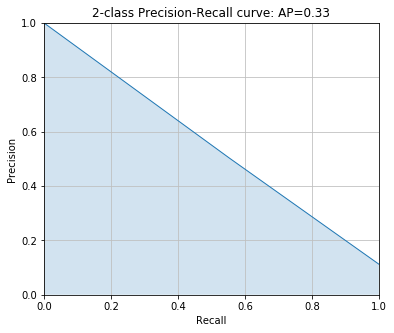

             precision    recall  f1-score   support

         no       0.94      0.93      0.94      6033
        yes       0.50      0.55      0.53       766

avg / total       0.89      0.89      0.89      6799

实际为 1 判定为 0的数量342 实际为 0 判定为 1 的数量 419
accuracy is 0.8880717752610678


In [108]:
predict_y = []
for test in test_data_x.values:
    predict_y.append(id3.dfs(test))
predict_y = np.array(predict_y)
print_all(predict_y)
# 无过采样,欠采样的结果
#                  precision    recall  f1-score   support

#          no       0.93      0.94      0.94      6033
#         yes       0.51      0.45      0.48       766

# avg / total       0.88      0.89      0.89      6799

# 实际为 1 判定为 0的数量420 实际为 0 判定为 1 的数量 337

In [109]:
### 
class Rule(object):
    '''
        返回的值为该属性下作为判别规则的时候，最小的误差率
    '''
    def __init__(self,feature_i,w,label):
        self.feature_i = feature_i
        self.w = w
        self.label = label
        self.is_less = False
        self.value = 1e9
        self.min_score = 1e9
    def calc(self):
        list_feature = list(set(self.feature_i))
        
        for i in range(len(list_feature) - 1):
            feature_value = (list_feature[i] + list_feature[i + 1]) / 2
            less_score = self.less(feature_value)
            more_score = self.more(feature_value)
            if more_score > less_score:
                if self.min_score > less_score:
                    self.is_less = True
                    self.value = feature_value
                    self.min_score = less_score
            else:
                if self.min_score > more_score:
                    self.is_less = False
                    self.value = feature_value
                    self.min_score = more_score
                    
    def less(self,feature):
        # 计算 <= feature y = 1 的错误率
        sum = 0.0
        for i,fea_label in enumerate(zip(self.feature_i,self.label)):
            fea = fea_label[0];label = fea_label[1]
            if fea < feature and label != 1:
                sum += self.w[i]
            elif fea > feature and label != -1:
                sum += self.w[i]
        return sum
    def more(self,feature):
        # 计算 > feature y = 1 的错误率
        sum = 0.0
        for i,fea_label in enumerate(zip(self.feature_i,self.label)):
            fea = fea_label[0];label = fea_label[1]
            if fea < feature and label != -1:
                sum += self.w[i]
            elif fea > feature and label != 1:
                sum += self.w[i]
        return sum
        
class Adaboost(object):
    def __init__(self,number_base_classifier):
        
        self.number_base_classifier = number_base_classifier # 基分类器的数量
        self.alpha = [0] * number_base_classifier # 每个分类器的权值
        self.clf_list = []
        self.classifier_count = 0
        
    def train(self,data , label): # dataFrame 和 Series
        n,feature =  data.shape
        # 重新建立索引
        data.index = [i for i in range(n)]
        label.index = [i for i in range(n)]
        label = list(map(lambda x: 2* x -1,label)) # 转换成 1,-1
        w = np.array([1 / n for i in range(n)]) # 初始化权重
        
        for class_i in range(self.number_base_classifier): # 依次训练一个弱分类器
            best = (-1,-1,False,1e9) # feature,value,is_less
            for feature_j in range(feature): # 
                feature_j_value = data.iloc[:,feature_j]
                rule = Rule(feature_j_value,w,label)
                rule.calc()
                
                best_tmp = (feature_j,rule.value,rule.is_less,rule.min_score)
                
                if best[3] > best_tmp[3]:
                    best = best_tmp
            e = best[3]
            print('min error {0} best {1}'.format(e,best))
            if e > 0.5: # 还没有猜的好
                break
            self.clf_list.append(best[:-1])
#             print(self.clf_list)
            alpha = np.log((1 - e) / e) / 2.0
            self.alpha[class_i] = alpha
            z_m = 0
            
            for i, data_i in enumerate(data.values):
                flag = self.getFlag(best,data_i,label[i])
                if flag  == 0:
                    print('wrong!!!!')
                z_m += (w[i] * np.exp(-alpha * flag))
                
            for i, data_i in enumerate(data.values):
                flag = self.getFlag(best,data_i,label[i])
                w[i] = w[i] * np.exp(-alpha * flag) / z_m
#             print(np.sum(w))
#             print('np.sum(w) {0}'.format(np.sum(w)))
            w /= np.sum(w)
            
            self.classifier_count += 1
            
    def getFlag(self,best,data_i,label_i):
        flag = 0;
        if best[2] is True:
            if data_i[best[0]] < best[1]:
                if label_i != 1:
                    flag = -1;
                else:
                    flag = 1
            else:
                if label_i == 1:
                    flag = -1
                else:
                    flag = 1
        elif best[2] is False:
            if data_i[best[0]] > best[1]:
                if label_i != 1:
                    flag = -1;
                else:
                    flag = 1
            else:
                if label_i == 1:
                    flag = -1
                else:
                    flag = 1
        return flag
    
    def predict(self,test): # np.ndarray
        sum = 0
        for class_i in range(self.classifier_count):
            g_m_x  = 0 
            best = self.clf_list[class_i]
            if best[2] is True:
                if test[best[0]] < best[1]:
                    g_m_x = 1
                else:
                    g_m_x = -1
            elif best[2] is False:
                if test[best[0]] > best[1]:
                    g_m_x = 1
                else:
                    g_m_x = -1
            sum += self.alpha[class_i] * g_m_x
        if sum > 0:
            return 1
        else:
            return 0
        

In [110]:
adaboost = Adaboost(number_base_classifier = 18)
adaboost.train(train_data_x,train_data_y)

min error 0.25477486820501094 best (1, 0.4076571007148625, False, 0.25477486820501094)
min error 0.217378976321766 best (8, -0.2665352768306319, True, 0.217378976321766)
min error 0.3489969409880167 best (1, 1.3409765615581202, False, 0.3489969409880167)
min error 0.3338477655986224 best (21, 0.9923612044041269, True, 0.3338477655986224)
min error 0.36038274286158445 best (9, -0.9479185062176695, True, 0.36038274286158445)
min error 0.36516170978689844 best (1, -0.30983500197227987, False, 0.36516170978689844)
min error 0.39246749164165046 best (14, 0.10193487111769317, False, 0.39246749164165046)
min error 0.4213855893222912 best (1, -0.5592674770724713, False, 0.4213855893222912)
min error 0.4337576883745418 best (1, 2.263540781379933, False, 0.4337576883745418)
min error 0.448825830957173 best (56, 0.0007345139895835739, False, 0.448825830957173)
min error 0.447596007955443 best (1, -0.6224645801366941, False, 0.447596007955443)
min error 0.44486783976813477 best (23, 0.044032340239

Average precision-recall score: 0.38


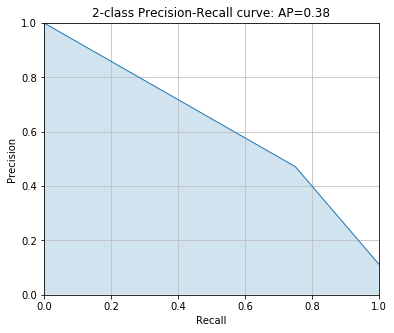

             precision    recall  f1-score   support

         no       0.97      0.89      0.93      6033
        yes       0.47      0.75      0.58       766

avg / total       0.91      0.88      0.89      6799

实际为 1 判定为 0的数量191 实际为 0 判定为 1 的数量 645
accuracy is 0.8770407412854831


In [111]:
predict_y = []
for test in test_data_x.values:
    predict_y.append(adaboost.predict(test))
predict_y = np.array(predict_y)
print_all(predict_y)
# 无过采样,欠采样的结果
#                  precision    recall  f1-score   support

#          no       0.92      0.98      0.95      6033
#         yes       0.63      0.29      0.39       766

# avg / total       0.88      0.90      0.88      6799

# 实际为 1 判定为 0的数量547 实际为 0 判定为 1 的数量 128

In [136]:
#### p-r 对比
p_no = [[0.98,0.94,0.97],[0.94,0.93,0.92]]
r_no = [[0.87,0.93,0.89],[0.95,0.94,0.98]]
f1_no = [[0.92,0.94,0.93],[0.95,0.94,0.95]]
p_yes = [[0.45,0.50,0.47],[0.60,0.51,0.63]]
r_yes = [[0.85,0.55,0.75],[0.56,0.45,0.29]]
f1_yes = [[0.59,0.53,0.58],[0.58,0.48,0.39]]

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 144x216 with 0 Axes>

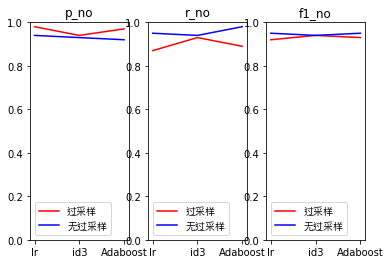

In [142]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname = '/System/Library/Fonts/PingFang.ttc')
plt.figure(figsize = (2,3))
plt.figure()
alg = ['lr','id3','Adaboost']
### 负样本比较
plt.subplot(1,3,1)
plt.plot(alg,p_no[0],c = 'r',label = '过采样')
plt.plot(alg,p_no[1],c = 'b',label = '无过采样')
plt.ylim(0,1)
plt.legend(prop = font)
plt.title('p_no')
### 
plt.subplot(1,3,2)
plt.plot(alg,r_no[0],c = 'r',label = '过采样')
plt.plot(alg,r_no[1],c = 'b',label = '无过采样')
plt.ylim(0,1)
plt.legend(prop = font)
plt.title('r_no')
###
plt.subplot(1,3,3)
plt.plot(alg,f1_no[0],c = 'r',label = '过采样')
plt.plot(alg,f1_no[1],c = 'b',label = '无过采样')
plt.ylim(0,1)
plt.legend(prop = font)
plt.title('f1_no')
plt.savefig('no.jpg')

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


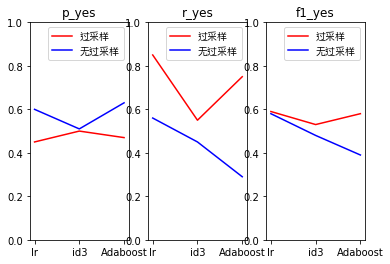

In [144]:
### 正样本比较
plt.subplot(1,3,1)
plt.plot(alg,p_yes[0],c = 'r',label = '过采样')
plt.plot(alg,p_yes[1],c = 'b',label = '无过采样')
plt.ylim(0,1)
plt.legend(prop = font)
plt.title('p_yes')
### 
plt.subplot(1,3,2)
plt.plot(alg,r_yes[0],c = 'r',label = '过采样')
plt.plot(alg,r_yes[1],c = 'b',label = '无过采样')
plt.ylim(0,1)
plt.legend(prop = font)
plt.title('r_yes')
###
plt.subplot(1,3,3)
plt.plot(alg,f1_yes[0],c = 'r',label = '过采样')
plt.plot(alg,f1_yes[1],c = 'b',label = '无过采样')
plt.ylim(0,1)
plt.legend(prop = font)
plt.title('f1_yes')
plt.savefig('yes.jpg')

In [228]:
def plot_index_other(predict_all, alg):
    cnt = 1
    plt.figure(figsize = (20,15))
    for alg_i, predict_prob_y in zip(alg,predict_all):
        average_precision = average_precision_score(test_data_y, predict_prob_y)
        print('Average precision-recall score: {0:0.2f} for algorithm {1}'.format(
              average_precision,alg_i))
        print('')
        print_report(predict_prob_y)
        precision, recall, _ = metrics.precision_recall_curve(test_data_y, predict_prob_y)
        plt.subplot(2,3,cnt)
        plt.xlim([0.0, 1.0])  
        plt.ylim([0.0, 1.0])
        plt.xlabel('Recall')  
        plt.ylabel('Precision')  
        plt.title('pr curve: AP={0:0.2f} alg {1}'.format(average_precision,alg_i))  
        plt.fill_between(recall, precision, alpha=0.2, color = 'b')  
        plt.grid(True, linestyle='-', color='0.75')  
        plt.plot(recall, precision, lw=1,color = 'b')    
        cnt += 1
    plt.savefig('all.jpg')
    

In [206]:
alg = ['RandomForestClassifier','KNeighborsClassifier','LinearSVC','Sequential','xgboost']
predict_y_all = []

In [210]:
rfc = RandomForestClassifier(n_estimators=400, oob_score=True)
rfc.fit(train_data_x,train_data_y)
predict_prob_y = rfc.predict_proba(test_data_x)[:,1]

In [211]:
predict_y_all.append(predict_prob_y)
# 无过采样,欠采样的结果
#                 precision    recall  f1-score   support

#          no       0.94      0.96      0.95      6033
#         yes       0.64      0.55      0.59       766

# avg / total       0.91      0.91      0.91      6799

# 实际为 1 判定为 0的数量346 实际为 0 判定为 1 的数量 240

In [212]:
classifier = KNeighborsClassifier()
classifier.fit(train_data_x,train_data_y)
predict_prob_y = classifier.predict_proba(test_data_x)[:,1]

In [213]:
predict_y_all.append(predict_prob_y)
# 无过采样,欠采样的结果
#                  precision    recall  f1-score   support

#          no       0.93      0.97      0.95      6033
#         yes       0.63      0.41      0.49       766

# avg / total       0.89      0.91      0.90      6799

# 实际为 1 判定为 0的数量455 实际为 0 判定为 1 的数量 185

In [214]:
clf = LinearSVC()
clf.fit(train_data_x,train_data_y)
predict_prob_y = clf.decision_function(test_data_x)

In [215]:
predict_y_all.append(predict_prob_y)
# 无过采样,欠采样的结果
#                 precision    recall  f1-score   support

#          no       0.90      1.00      0.95      6033
#         yes       0.84      0.14      0.24       766

# avg / total       0.89      0.90      0.87      6799

# 实际为 1 判定为 0的数量661 实际为 0 判定为 1 的数量 20

In [216]:
X_train = np.reshape(train_data_x,(train_data_x.shape[0],-1))
X_test = np.reshape(test_data_x,(test_data_x.shape[0],-1))
# print(X_train.shape,X_test.shape)
y_train = np_utils.to_categorical(train_data_y,num_classes = 2)
y_test = np_utils.to_categorical(test_data_y,num_classes = 2)

model = Sequential([
    Dense(256,input_dim = 57),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])

rmsprop = RMSprop(lr = 0.01,rho=0.9, epsilon=1e-08, decay=0.0)
# ada = Adagrad(lr=0.01, epsilon=None, decay=0.0)
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = rmsprop,loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.fit(X_train,y_train,epochs = 100,batch_size = 32)

Epoch 1/100
46284/46284 [==============================] - 2s 35us/step - loss: 0.2835 - acc: 0.8792
Epoch 2/100
46284/46284 [==============================] - 1s 30us/step - loss: 0.2520 - acc: 0.8941
Epoch 3/100
46284/46284 [==============================] - 1s 30us/step - loss: 0.2435 - acc: 0.8969
Epoch 4/100
46284/46284 [==============================] - 1s 30us/step - loss: 0.2377 - acc: 0.9014
Epoch 5/100
46284/46284 [==============================] - 1s 29us/step - loss: 0.2321 - acc: 0.9026
Epoch 6/100
46284/46284 [==============================] - 1s 29us/step - loss: 0.2271 - acc: 0.9073
Epoch 7/100
46284/46284 [==============================] - 1s 29us/step - loss: 0.2205 - acc: 0.9091
Epoch 8/100
46284/46284 [==============================] - 1s 29us/step - loss: 0.2182 - acc: 0.9119
Epoch 9/100
46284/46284 [==============================] - 1s 30us/step - loss: 0.2175 - acc: 0.9119
Epoch 10/100
46284/46284 [==============================] - 1s 29us/step - loss: 0.2112 - a

In [217]:
predict_y = model.predict(X_test)
predict_y_all.append(predict_y[:,1])
# 无过采样,欠采样的结果
#                 precision    recall  f1-score   support

#          no       0.94      0.93      0.94      6033
#         yes       0.51      0.56      0.53       766

# avg / total       0.89      0.89      0.89      6799

# 实际为 1 判定为 0的数量339 实际为 0 判定为 1 的数量 412

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


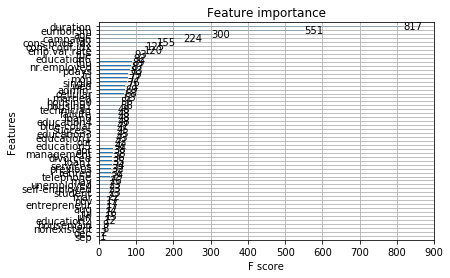

In [218]:
##### xgboost 
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

plst = params.items()

dtrain = xgb.DMatrix(train_data_x, train_data_y)
num_rounds = 200
model = xgb.train(plst, dtrain, num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(test_data_x)
predict_prob_y = model.predict(dtest)

predict_y_all.append(predict_prob_y)

# 显示重要特征
plot_importance(model)
plt.show()
# 无过采样,欠采样的结果
#               precision    recall  f1-score   support

#          no       0.95      0.96      0.95      6033
#         yes       0.62      0.57      0.60       766

# avg / total       0.91      0.91      0.91      6799

# 实际为 1 判定为 0的数量326 实际为 0 判定为 1 的数量 267

Average precision-recall score: 0.63 for algorithm RandomForestClassifier
             precision    recall  f1-score   support

         no       0.96      0.92      0.94      6033
        yes       0.54      0.73      0.62       766

avg / total       0.92      0.90      0.91      6799

实际为 1 判定为 0的数量207 实际为 0 判定为 1 的数量 472
accuracy is 0.900132372407707
Average precision-recall score: 0.46 for algorithm KNeighborsClassifier
             precision    recall  f1-score   support

         no       0.96      0.89      0.93      6033
        yes       0.46      0.71      0.56       766

avg / total       0.90      0.87      0.88      6799

实际为 1 判定为 0的数量224 实际为 0 判定为 1 的数量 638
accuracy is 0.8732166495072805
Average precision-recall score: 0.63 for algorithm LinearSVC
             precision    recall  f1-score   support

         no       0.93      0.98      0.95      6033
        yes       0.70      0.39      0.50       766

avg / total       0.90      0.91      0.90      6799

实际为 1 判定为 0

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


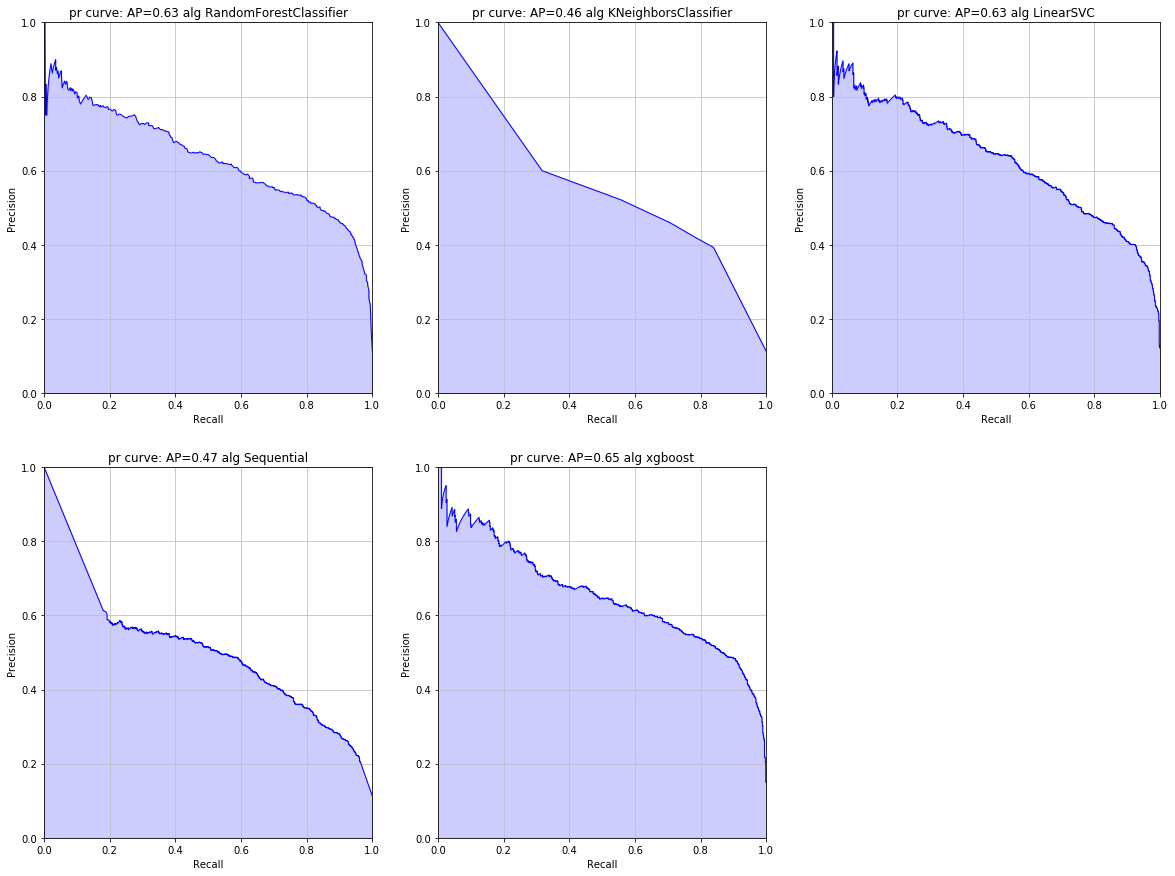

In [229]:
plot_index_other(predict_y_all,alg)